# Moho of Moon

本程序将用Urida的南美莫霍面反演程序的基本结构反演月球全月面的莫霍面深度

## package imports

In [35]:
# Insert the plots into the notebook
%matplotlib inline

In [36]:
from __future__ import division
import datetime
import zipfile
import cPickle as pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer
import pandas as pd
import warnings
warnings.simplefilter('ignore')
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando
import os

In [37]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 0.5


In [38]:
from mohoinv import (MohoGravityInvSpherical, TesseroidRelief, make_mesh,
                     split_data, score_test_set, score_seismic_constraints, 
                     score_all, fit_all, predict_seismic)

In [39]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 20


## Load data
data is in the folder `data`

In [ ]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))


data_file = os.path.join(
    PROJECT_ROOT,
    "data",
    "boueguer_tesseroid_withoutmare_zhishu_1deg.csv"
)

df = pd.read_csv(data_file)
lon_raw = np.sort(df['lon'].unique())
lat_raw = np.sort(df['lat'].unique())
nlat = len(np.unique(lat_raw))
nlon = len(np.unique(lon_raw))

grav_grid = df.pivot(index='lat', columns='lon', values='deltaN').loc[lat_raw, lon_raw].values
topo_grid  = df.pivot(index='lat', columns='lon', values='topo').loc[lat_raw, lon_raw].values
LON, LAT = np.meshgrid(lon_raw, lat_raw) 

NameError: name '__file__' is not defined

In [ ]:
print(np.nanmax(topo_grid), np.nanmin(topo_grid))

(-3464816.010068, -3482592.11196)


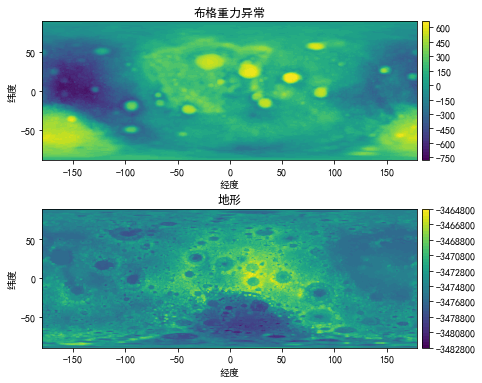

In [ ]:
def plot_grav_topo(lon, lat, grav_grid, topo_grid):
    # 中文与负号（Python 2.7 必须）
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    fig = plt.figure(figsize=(8, 6))

    # ---------- 上图：布格重力异常 ----------
    ax1 = fig.add_subplot(211)
    cf1 = ax1.contourf(lon, lat, grav_grid, levels=50)
    ax1.set_xlabel(u'经度')
    ax1.set_ylabel(u'纬度')
    ax1.set_title(u'布格重力异常')
    fig.colorbar(cf1, ax=ax1, pad=0.01)

    # ---------- 下图：地形 ----------
    ax2 = fig.add_subplot(212)
    cf2 = ax2.contourf(lon, lat, topo_grid, levels=50)
    ax2.set_xlabel(u'经度')
    ax2.set_ylabel(u'纬度')
    ax2.set_title(u'地形')
    fig.colorbar(cf2, ax=ax2, pad=0.01)

    plt.subplots_adjust(hspace=0.35)
    plt.show()
    
plot_grav_topo(lon_raw, lat_raw, grav_grid, topo_grid)

In [ ]:
test=True

if test:
    lon_min = -40
    lon_max = 5
    lat_min = 10
    lat_max = 55
    result_filename='test_run_approach.pkl'
else:
    lon_min = -180
    lon_max = 180
    lat_min = -90
    lat_max = 90
    result_filename='run_approach.pkl'
    
result_file_name = os.path.join(
    PROJECT_ROOT,
    "result",
    result_filename
)

In [ ]:
lon_indices = np.where((lon_raw >= lon_min) & (lon_raw <= lon_max))[0]
lat_indices = np.where((lat_raw >= lat_min) & (lat_raw <= lat_max))[0]

LON_sub = LON[np.ix_(lat_indices, lon_indices)]
LAT_sub = LAT[np.ix_(lat_indices, lon_indices)]
topo_grid_sub = topo_grid[np.ix_(lat_indices, lon_indices)]
grav_grid_sub = grav_grid[np.ix_(lat_indices, lon_indices)]

LAT_sub = np.array(LAT_sub, dtype=np.float64)
LON_sub = np.array(LON_sub, dtype=np.float64)
topo_grid_sub = np.array(topo_grid_sub, dtype=np.float64)
grav_grid_sub = np.array(grav_grid_sub, dtype=np.float64)

LAT_flat = LAT_sub.flatten()
LON_flat = LON_sub.flatten()
topo_flat = topo_grid_sub.flatten()
grav_flat = grav_grid_sub.flatten()

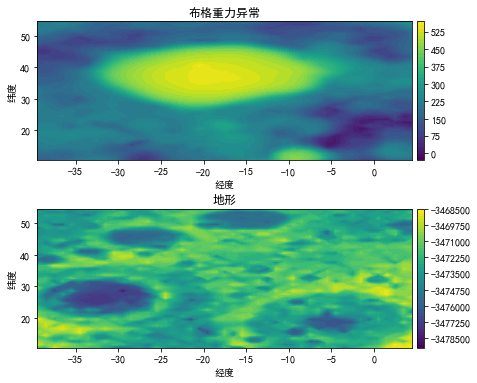

In [ ]:
plot_grav_topo(np.sort(np.unique(LON_sub)), np.sort(np.unique(LAT_sub)), grav_grid_sub, topo_grid_sub)

In [ ]:
full_data=[LAT_flat,LON_flat,11e3*np.ones_like(grav_flat),grav_flat]
full_shape=LAT_sub.shape
print('Number of data points in lat and lon: {}'.format(full_shape))

Number of data points in lat and lon: (45L, 45L)


## Cross-validation

画图的函数放这里

In [ ]:

def plot_regul(scores_regul,regul_params):
    idx_min=np.argmin(scores_regul)
    best_regul = regul_params[idx_min]
    best_score = scores_regul[idx_min]

    print("best lambda =", best_regul)
    print("best score  =", best_score)
    plt.figure(figsize=(6, 4))
    plt.loglog(regul_params, scores_regul,
            'o-', linewidth=2, markersize=6, label='Misfit')
    plt.loglog(best_regul, best_score,
            'ro', markersize=10, label='Minimum')
    plt.xlabel('Regularization parameter lambda')
    plt.ylabel('Misfit / Score')
    plt.title('Cross-validation curve (log-log)')
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.show()

def plot_residuals(solution, bins=20):
    residuals = solution[0].residuals()
    mean_res = residuals.mean()
    std_res  = residuals.std()
    plt.figure(figsize=(3, 2.5))
    plt.hist(residuals,
             bins=bins,
             density=True,
             histtype='stepfilled',
             alpha=0.8)
    plt.text(0.65, 0.80,
             "mean = %.2f\nstd  = %.2f" % (mean_res, std_res),
             transform=plt.gca().transAxes,
             fontsize=9)
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0.4)
    plt.show()
    
def plot_observe_predict(LON_sub,LAT_sub,grav_grid_sub,lon,lat,solution,shape):
    predicted = solution[0].predicted()
    fig = plt.figure(figsize=(8, 6))

    ax1 = fig.add_subplot(211)
    cf1 = ax1.contourf(np.sort(np.unique(LON_sub)), np.sort(np.unique(LAT_sub)), grav_grid_sub, levels=50)
    ax1.set_xlabel(u'经度')
    ax1.set_ylabel(u'纬度')
    ax1.set_title(u'观测数据')
    fig.colorbar(cf1, ax=ax1, pad=0.01)

    ax2 = fig.add_subplot(212)
    cf2 = ax2.contourf(np.sort(np.unique(lon)), np.sort(np.unique(lat)), np.reshape(predicted,shape), levels=50)
    ax2.set_xlabel(u'经度')
    ax2.set_ylabel(u'纬度')
    ax2.set_title(u'正演预测数据')
    fig.colorbar(cf2, ax=ax2, pad=0.01)

    plt.subplots_adjust(hspace=0.35)
    plt.show()

def plot_moho(solution,lon,lat,shape):
    moho = solution.estimate_
    relief = moho.relief.copy()
    fig, ax = plt.subplots(figsize=(8, 4))

    cf2 = ax.contourf(np.sort(np.unique(lon)), np.sort(np.unique(lat)), np.reshape(relief,shape), levels=50)
    ax.set_xlabel(u'经度')
    ax.set_ylabel(u'纬度')
    ax.set_title(u'莫霍面深度')
    fig.colorbar(cf2, ax=ax, pad=0.01)

    plt.subplots_adjust(hspace=0.35)
    plt.show()
    
def plot_refden_score(scores_refden,densities,reference_levels):
    fig, ax = plt.subplots(figsize=(6, 4))

    idx = np.unravel_index(np.nanargmin(scores_refden), scores_refden.shape)
    j_min, i_min = idx
    best_ref = reference_levels[i_min]
    best_den = densities[j_min]
    best_rms = scores_refden[j_min, i_min]
    cf2 = ax.contourf(reference_levels,densities, scores_refden, levels=50, cmap='BuPu_r')
    ax.plot(best_ref,best_den,marker='*',color='red',markersize=14,markeredgecolor='k',label='Minimum RMS')
    ax.set_xlabel(u'参考平面')
    ax.set_ylabel(u'密度对比')
    ax.set_title(u'RMS')
    fig.colorbar(cf2, ax=ax, pad=0.01)
    ax.legend()

    plt.subplots_adjust(hspace=0.35)
    plt.show()

In [ ]:
inversion_set, test_set, shape = split_data(full_data, full_shape, every_other=2)

print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], 
                                                             shape[0]*shape[1]))
print("Number of test set points: {}".format(test_set[0].size))

lat, lon, height, data = inversion_set

Number of inversion grid points: 23 x 23 = 529
Number of test set points: 1496


生成一系列反演器，首先看正则化参数

In [ ]:
area = (lat.min(), lat.max(), lon.min(), lon.max())
mesh = make_mesh(area, shape)
regul = Smoothness2D(mesh.shape)
initial = -40e3*np.ones(mesh.size) 

densities = np.arange(400, 800 + 1, 50)# kg/m³
reference_levels = np.arange(-60e3, -20e3 + 1, 5e3)# m
regul_params = np.logspace(-10, -2, 16)
config = dict(method='newton', initial=initial, tol=0.2, maxit=6)

misfit=MohoGravityInvSpherical(lat, lon, height, data, mesh, njobs=ncpu)
misfit.set_density(densities[-1]).set_reference(reference_levels[-1])

solvers = [(misfit + mu*regul).config(**config) 
           for mu in regul_params]

result=dict()
result['densities']=densities
result['reference_levels']=reference_levels
result['regul_params']=regul_params
result['lon_sub']=np.sort(np.unique(LON_sub))
result['lat_sub']=np.sort(np.unique(LAT_sub))
result['observe']=grav_grid_sub

In [ ]:
solutions=fit_all(solvers,njobs=ncpu)

In [ ]:
models_regul = [s.estimate_ for s in solutions]
scores_regul = score_all(models_regul, test_set, points=False, njobs=ncpu)
idx_min=np.argmin(scores_regul)

In [ ]:
# result['solutions_regul']=solutions
result['scores_regul']=scores_regul
#result['best_solution_regul']=solutions[idx_min]
result['lon']=np.sort(np.unique(lon))
result['lat']=np.sort(np.unique(lat))
result['best_solutions_regul_predict_grid']=np.reshape(solutions[idx_min][0].predicted(),shape)
moho = solutions[idx_min].estimate_
result['best_solutions_regul_moho_grid']=np.reshape(moho.relief.copy(),shape)
result['regul_residuals']=solutions[idx_min][0].residuals()

('best lambda =', 1e-10)
('best score  =', 128.7521883508733)


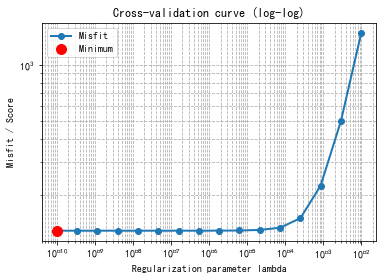

In [ ]:
plot_regul(scores_regul,regul_params)

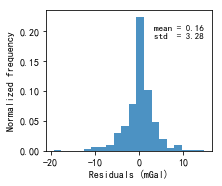

In [ ]:
plot_residuals(solutions[idx_min])

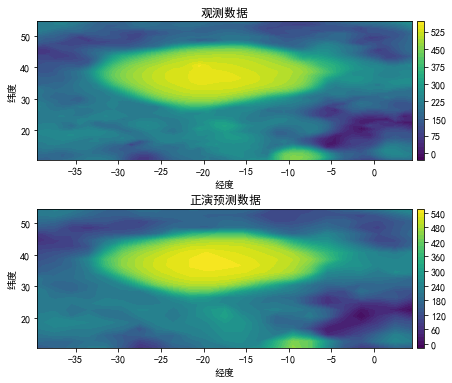

In [ ]:
plot_observe_predict(LON_sub,LAT_sub,grav_grid_sub,lon,lat,solutions[idx_min],shape)

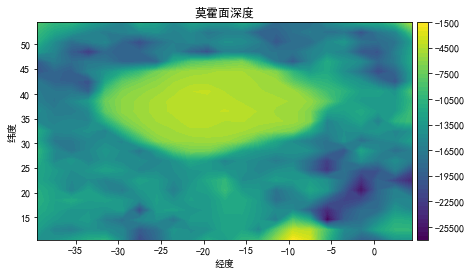

In [ ]:
plot_moho(solutions[idx_min],lon,lat,shape)

下面进行对密度和参考平面深度的反演

In [ ]:
def set_ref_dens(solver, ref, dens):
    res = solver.copy(deep=True)
    res[0].set_density(dens).set_reference(ref)
    return res

solvers = [set_ref_dens(solutions[idx_min], ref, dens) 
           for dens in densities
           for ref in reference_levels]

In [ ]:
%time solutions = fit_all(solvers, njobs=ncpu)

Wall time: 34.1 s


In [ ]:
models_refden = [s.estimate_ for s in solutions]
cv_shape=(len(densities),len(reference_levels))
scores_refden = score_all(models_refden, test_set, points=False, njobs=ncpu).reshape(cv_shape)

In [ ]:
idx = np.unravel_index(np.nanargmin(scores_refden), scores_refden.shape)
j_min, i_min = idx
best_ref = reference_levels[i_min]
best_den = densities[j_min]
best_rms = scores_refden[j_min, i_min]
idx_refden_min=np.argmin(scores_refden)

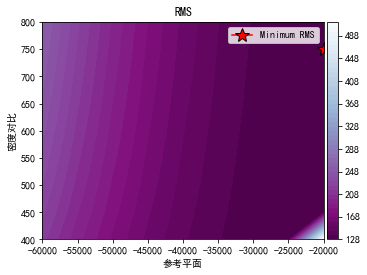

In [ ]:
plot_refden_score(scores_refden,densities,reference_levels)

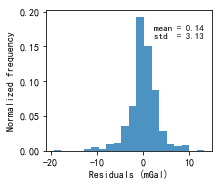

In [ ]:
plot_residuals(solutions[idx_refden_min])

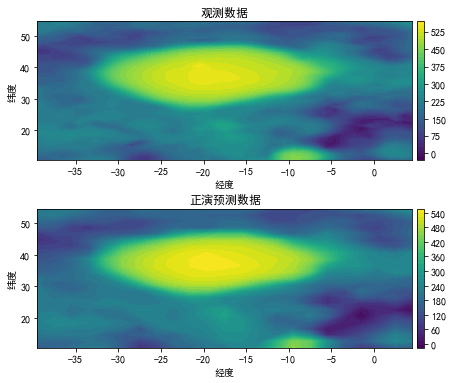

In [ ]:
plot_observe_predict(LON_sub,LAT_sub,grav_grid_sub,lon,lat,solutions[idx_refden_min],shape)

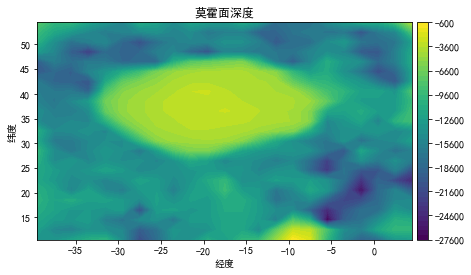

In [ ]:
plot_moho(solutions[idx_refden_min],lon,lat,shape)

In [ ]:
#result['solutions_refden']=solutions
result['scores_refden']=scores_refden
#result['best_solution_refden']=solutions[idx_refden_min]
result['best_solutions_refden_predict_grid']=np.reshape(solutions[idx_refden_min][0].predicted(),shape)
moho = solutions[idx_refden_min].estimate_
result['best_solutions_refden_moho_grid']=np.reshape(moho.relief.copy(),shape)
result['refden_residuals']=solutions[idx_refden_min][0].residuals()

In [ ]:
with open(result_file_name, 'wb') as f:
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL)

IOError: [Errno 2] No such file or directory: 'scripts/result/test_run_approach.pkl'